Iteration 000 | Best MSE: 0.001696
Iteration 020 | Best MSE: 0.001696
Iteration 040 | Best MSE: 0.001696
Iteration 060 | Best MSE: 0.001696
Iteration 080 | Best MSE: 0.001696

✅ Fitted Parameters:
K  (carrying capacity): 1.1481
r  (growth rate):       0.7190
t0 (inflection point):  4.7796
Final MSE:              0.001696

True Parameters:
K=1.2, r=0.6, t0=5.0


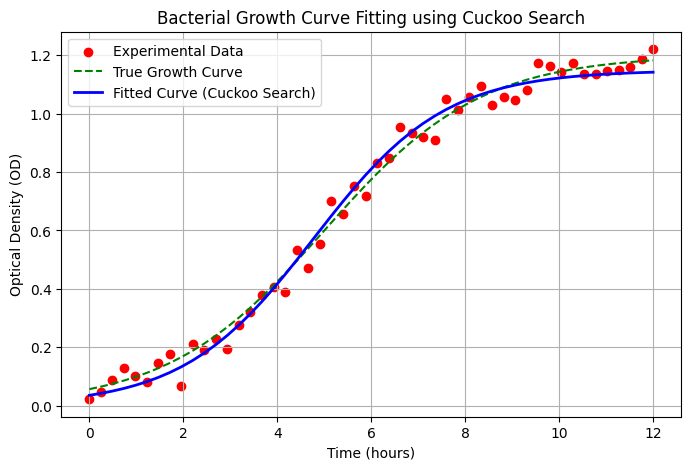

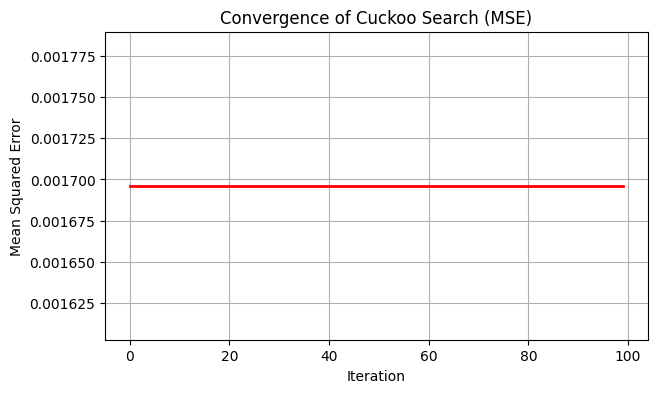

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

# -----------------------------
# 1. Generate Synthetic Bacterial Growth Data
# -----------------------------

# True biological parameters (unknown in real life)
K_true = 1.2     # carrying capacity
r_true = 0.6     # growth rate
t0_true = 5.0    # inflection point

# Time points (hours)
t = np.linspace(0, 12, 50)

# True growth curve
def logistic_growth(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

N_true = logistic_growth(t, K_true, r_true, t0_true)

# Add experimental noise
noise = np.random.normal(0, 0.05, size=t.shape)
N_obs = N_true + noise

# -----------------------------
# 2. Objective Function: MSE between observed and predicted
# -----------------------------
def fitness_function(params):
    K, r, t0 = params
    N_pred = logistic_growth(t, K, r, t0)
    return np.mean((N_obs - N_pred)**2)

# -----------------------------
# 3. Levy Flight (for Cuckoo Search)
# -----------------------------
def levy_flight(Lambda, size):
    sigma = (math.gamma(1 + Lambda) * math.sin(math.pi * Lambda / 2) /
             (math.gamma((1 + Lambda) / 2) * Lambda * 2 ** ((Lambda - 1) / 2))) ** (1 / Lambda)
    u = np.random.normal(0, sigma, size=size)
    v = np.random.normal(0, 1, size=size)
    step = u / (np.abs(v) ** (1 / Lambda))
    return step

# -----------------------------
# 4. Cuckoo Search Algorithm
# -----------------------------
n = 20             # number of nests
pa = 0.25          # fraction of nests to abandon
iterations = 100   # iterations
bounds = np.array([
    [0.5, 2.0],   # K range
    [0.1, 1.0],   # r range
    [0.0, 10.0]   # t0 range
])
Lb = bounds[:, 0]
Ub = bounds[:, 1]

# Initialize nests randomly
nests = np.random.uniform(Lb, Ub, size=(n, 3))
fitness = np.array([fitness_function(x) for x in nests])

best_idx = np.argmin(fitness)
best = nests[best_idx].copy()
best_fitness = fitness[best_idx]

convergence = []

for t_iter in range(iterations):
    new_nests = np.zeros_like(nests)

    for i in range(n):
        step = 0.01 * levy_flight(1.5, 3) * (nests[i] - best)
        new_nest = nests[i] + step * np.random.randn(3)
        new_nest = np.clip(new_nest, Lb, Ub)
        new_nests[i] = new_nest

    new_fitness = np.array([fitness_function(x) for x in new_nests])

    # Replace if better
    for i in range(n):
        if new_fitness[i] < fitness[i]:
            fitness[i] = new_fitness[i]
            nests[i] = new_nests[i]

    # Abandon fraction
    num_abandon = int(pa * n)
    worst_idx = np.argsort(fitness)[-num_abandon:]
    nests[worst_idx] = np.random.uniform(Lb, Ub, size=(num_abandon, 3))
    fitness[worst_idx] = [fitness_function(x) for x in nests[worst_idx]]

    # Update best
    best_idx = np.argmin(fitness)
    if fitness[best_idx] < best_fitness:
        best = nests[best_idx].copy()
        best_fitness = fitness[best_idx]

    convergence.append(best_fitness)

    if t_iter % 20 == 0:
        print(f"Iteration {t_iter:03d} | Best MSE: {best_fitness:.6f}")

# -----------------------------
# 5. Results
# -----------------------------
K_fit, r_fit, t0_fit = best
print("\n✅ Fitted Parameters:")
print(f"K  (carrying capacity): {K_fit:.4f}")
print(f"r  (growth rate):       {r_fit:.4f}")
print(f"t0 (inflection point):  {t0_fit:.4f}")
print(f"Final MSE:              {best_fitness:.6f}")

print("\nTrue Parameters:")
print(f"K={K_true}, r={r_true}, t0={t0_true}")

# -----------------------------
# 6. Plot Results
# -----------------------------
plt.figure(figsize=(8,5))
plt.scatter(t, N_obs, label="Experimental Data", color='red')
plt.plot(t, logistic_growth(t, K_true, r_true, t0_true), 'g--', label="True Growth Curve")
plt.plot(t, logistic_growth(t, K_fit, r_fit, t0_fit), 'b-', linewidth=2, label="Fitted Curve (Cuckoo Search)")
plt.xlabel("Time (hours)")
plt.ylabel("Optical Density (OD)")
plt.title("Bacterial Growth Curve Fitting using Cuckoo Search")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 7. Convergence Plot
# -----------------------------
plt.figure(figsize=(7,4))
plt.plot(convergence, 'r-', linewidth=2)
plt.title("Convergence of Cuckoo Search (MSE)")
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error")
plt.grid(True)
plt.show()
